In [13]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as st
import statsmodels.api as sm
import forecast
from pandas import DataFrame
from sklearn.cross_validation import train_test_split
from statsmodels.sandbox.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from dateutil.parser import parse
import scipy.stats as scs
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
#Stop warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Only running the models on store 1 for now.

In [2]:
ts=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True)
ts2=pd.read_csv('Rossman Sales.csv')
ts2 = ts2[ts2['Store'] ==1]

### EDA

In [3]:
def generateMonSales(storenum, allstores):
    """Returns monthly sales for any particular store we specify"""
    data=pd.read_csv('Rossman Sales.csv')
    if allstores == False:
        data = data[data['Store'] ==storenum]
    #Parse string dates into datetime object:
    newdate = []
    for x in data['Date']:
        newdate.append(parse(x))
    data['Date'] = newdate
    #Sort the data by month:
    month = []
    for x in data['Date']:
        month.append(x.month)
    data['Month'] = month
    monthlysales = data.groupby(data['Month'])
    return monthlysales.sum()['Sales']

In [4]:
def plotGraph(data, storenum, allstores):
    """Generates plot of univariate sales over a year"""
    fig, ax = plt.subplots()
    data.plot(color='red')
    ax.set_xlabel('Month')
    
    if allstores == False:
        ax.set_ylabel('Sales')
        ax.set_title('Sales over time for store %s' %storenum)
    else:
        ax.set_ylabel('Sales $100 million')
        ax.set_title('Sales over months for all stores')
    sns.despine()
    plt.show()

In [5]:
def processdata(storenumber):
    """Get a single store, and transform holiday column."""
    finaldata=pd.read_csv('Rossman Sales.csv')
    finaldata = finaldata[finaldata['Store'] ==storenumber]
#    noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
#    noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
    dummies = pd.get_dummies(finaldata[['StateHoliday']],  drop_first=True)
    finaldata=finaldata.join(dummies)
    finaldata.rename(columns={'StateHoliday_0':'NoHoliday',
                                        'StateHoliday_a': 'PublicHoliday', 
                                        'StateHoliday_b': 'EasterHoliday', 
                                        'StateHoliday_c':'ChristmasHoliday'}, inplace=True)
    del finaldata['NoHoliday']
    del finaldata['StateHoliday']
    del finaldata['Store']
    return finaldata

In [3]:
def processdata2(storenumber, allStores):
    """Get a single store, remove weekends, and holidays."""
    finaldata=pd.read_csv('Rossman Sales.csv')
    if allStores == False:
        finaldata = finaldata[finaldata['Store'] ==storenumber]
    noweekendfinaldata = finaldata[finaldata['DayOfWeek'] != 6]
    noweekendfinaldata2 = noweekendfinaldata[noweekendfinaldata['DayOfWeek'] != 7]
    dummies = pd.get_dummies(noweekendfinaldata2[['StateHoliday']],  drop_first=True)
    noweekendfinaldata2=noweekendfinaldata2.join(dummies)
    noweekendfinaldata2.rename(columns={'StateHoliday_0':'NoHoliday',
                                        'StateHoliday_a': 'PublicHoliday', 
                                        'StateHoliday_b': 'EasterHoliday', 
                                        'StateHoliday_c':'ChristmasHoliday'}, inplace=True)

    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['PublicHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['EasterHoliday'] != 1]
    noweekendfinaldata2 = noweekendfinaldata2[noweekendfinaldata2['ChristmasHoliday'] != 1]
    del noweekendfinaldata2['NoHoliday']
    del noweekendfinaldata2['StateHoliday']
    del noweekendfinaldata2['Store']
    del noweekendfinaldata2['PublicHoliday']
    del noweekendfinaldata2['EasterHoliday']
    del noweekendfinaldata2['ChristmasHoliday']
    return noweekendfinaldata2

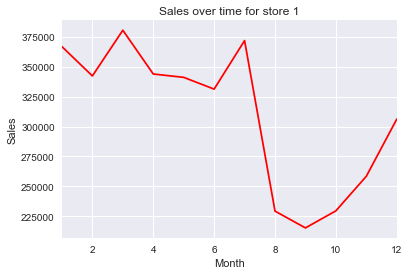

In [74]:
plotGraph(generateMonSales(1, False),1, False) 

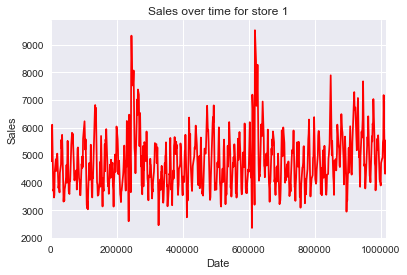

In [122]:
fig, ax = plt.subplots()
processdata2(1, False)['Sales'].plot(color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time for store 1')
sns.despine()
plt.show()

### Sales for all stores combined 

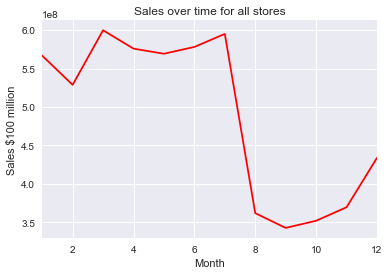

In [78]:
plotGraph(generateMonSales(1, True),1, True)

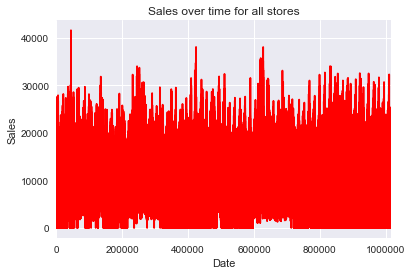

In [121]:
fig, ax = plt.subplots()
processdata2(1, True)['Sales'].plot(color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales over time for all stores')
sns.despine()
plt.show()

Now only analysing store 1

In [4]:
finaldata = processdata(1)

NameError: name 'processdata' is not defined

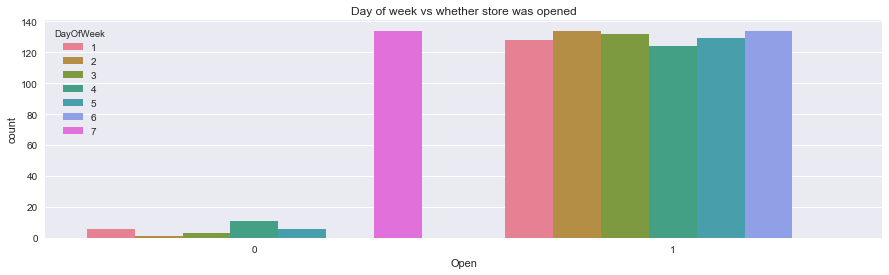

In [90]:
#Plot to see what days stores are closed
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Day of week vs whether store was opened')

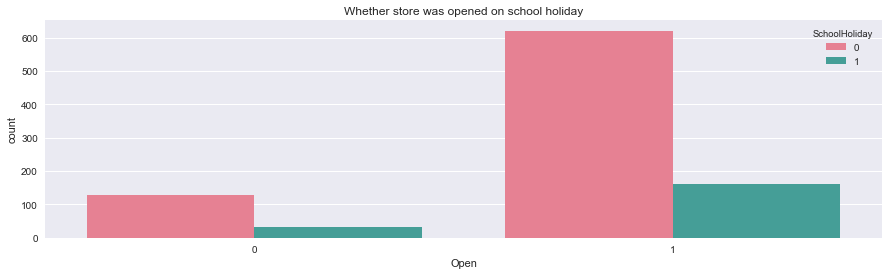

In [92]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open', hue='SchoolHoliday',data=finaldata,palette="husl", ax=axis1)
plt.title('Whether store was opened on school holiday')
#No school holiday is pink and school holiday is green

Stores tend to be opened most of the time even if there was a school holiday. The right 2 columns denotes the count of the stores are opened and then broken down into whether was it a school holiday or not when it was opened.

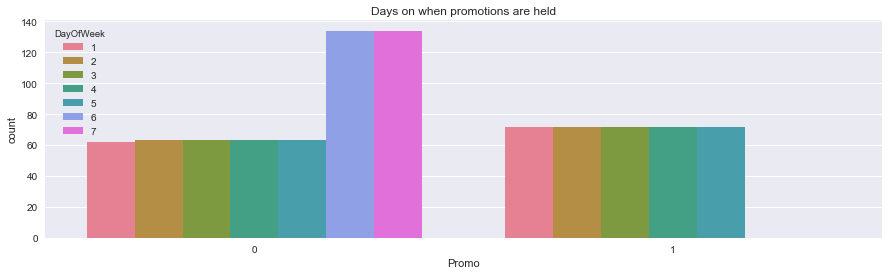

In [93]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Promo', hue='DayOfWeek',data=finaldata,palette="husl", ax=axis1)
plt.title('Days on when promotions are held')
#Promotion are spread over the days

Promotions uniformly spread throughout the week. No promotions at all on the weekends since stores are closed.

In [100]:
def convertDates():
    """Converts date variable into year and month."""
    data=pd.read_csv('Rossman Sales.csv')
    data = data[data['Store'] ==1]
    data['Year'] = data['Date'].apply(lambda x: int(str(x)[:4]))
    data['Month'] = data['Date'].apply(lambda x: int(str(x)[5:7]))
    return data

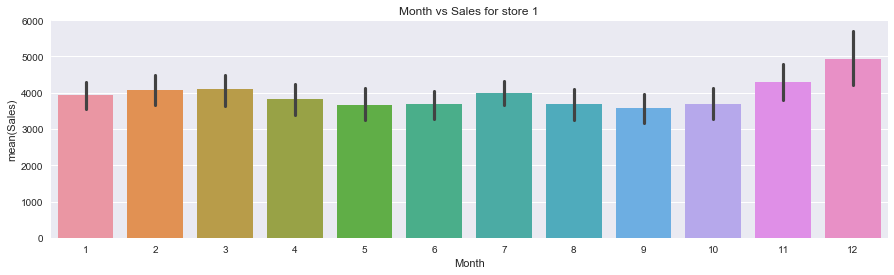

In [104]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Month',y='Sales', data=convertDates(), ax=axis1)
plt.title('Month vs Sales for store 1')

Store 1 tends to sell more goods during November and December

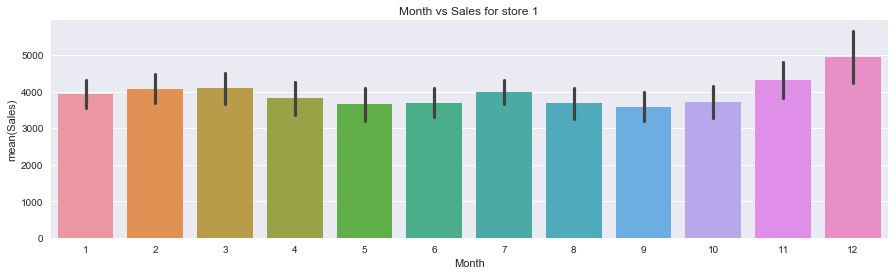

In [109]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Month',y='Sales', data=convertDates(), ax=axis1)
plt.title('Month vs Sales for store 1')

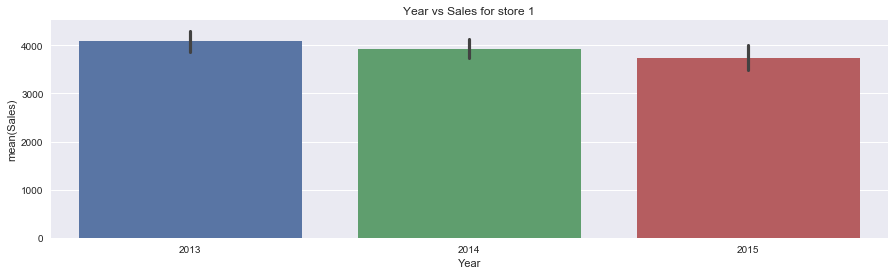

In [105]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.barplot(x='Year',y='Sales', data=convertDates(), ax=axis1)
plt.title('Year vs Sales for store 1')

Sales has fallen throughout the years.

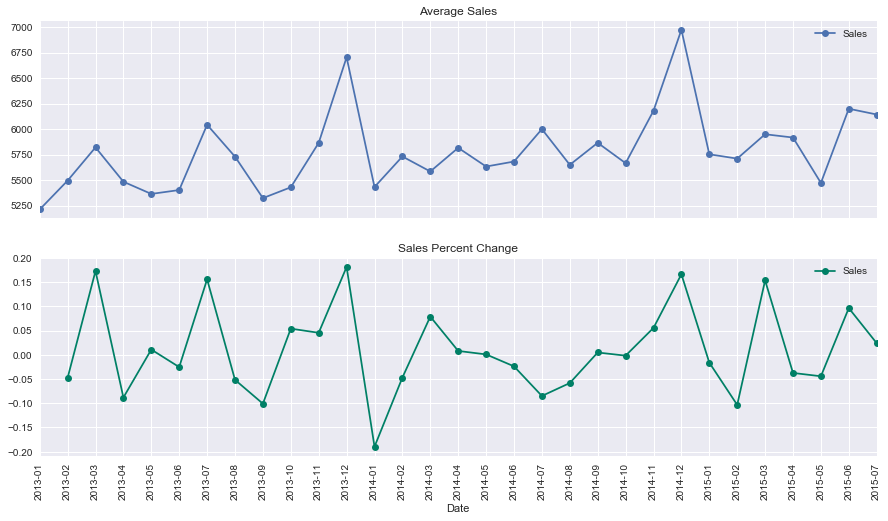

In [111]:
rossman = pd.read_csv('Rossman Sales.csv')
rossman['Year']  = rossman['Date'].apply(lambda x: int(str(x)[:4]))
rossman['Month'] = rossman['Date'].apply(lambda x: int(str(x)[5:7]))
rossman['Date'] = rossman['Date'].apply(lambda x: (str(x)[:7]))

average_sales    = rossman.groupby('Date')["Sales"].mean()
pct_change_sales = rossman.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")

Talk about trends and tell me if you notice anything

# Benchmark Model for store 1

I've removed weekends in order to make the forecasting easier.

In [5]:
benchmarkdata = processdata2(1, False)
benchmarkdata.head()

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
0,5,2015-07-31,5263,555,1,1,1
1115,4,2015-07-30,5020,546,1,1,1
2230,3,2015-07-29,4782,523,1,1,1
3345,2,2015-07-28,5011,560,1,1,1
4460,1,2015-07-27,6102,612,1,1,1


In [140]:
def test_stationarity(timeseries):
    """Test whether time series is stationary or not using Dickey-Fuller Test."""
    #Determing rolling statistics:
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [141]:
#Set the index to be the date and grab only sales values.
benchmarkdata = benchmarkdata.set_index('Date')
benchmarkvalues = benchmarkdata.iloc[:,1].values

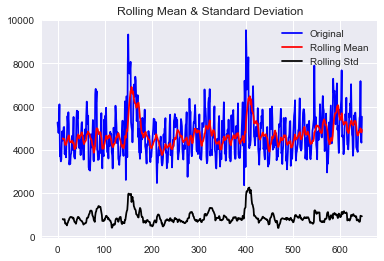

Results of Dickey-Fuller Test:
Test Statistic                  -3.863763
p-value                          0.002318
#Lags Used                      20.000000
Number of Observations Used    626.000000
Critical Value (1%)             -3.440839
Critical Value (5%)             -2.866168
Critical Value (10%)            -2.569235
dtype: float64


In [142]:
test_stationarity(benchmarkvalues)

Since P-value is less than 0.05, this means that we reject the $H_0$ which was that the data is not stationary. Therefore, the data is stationary.

For the graph, rolling mean and standard deviation means at any time t, we take the average of the past 12 months before it. From that, we can see whether has the mean/variance been constant over time, an important requirement for stationarity. You can read more at: https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Since data is stationary, we can run alot of models on it!

In [143]:
def acfpacfplot(ts):
    """Computes the ACF and PACF Plots."""
    lag_acf = acf(ts, nlags=20)
    lag_pacf = pacf(ts, nlags=20, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

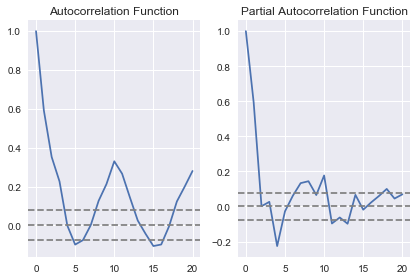

In [146]:
acfpacfplot(benchmarkvalues)

Upper and lower lines are confidence intervals. To determine p and q to use for ARIMA model, we look at where does it cross the upper bound for the first time. From this, it appears that it crosses the upper bound at approximately 4 for ACF and 2 for PACF graph. So from the ACF plot, we set q = 4 and from PACF plot, we set p = 2.



We now check for linearity by plotting 1 lag of sales vs sales to see whether AR(1) model is suitable first off all.

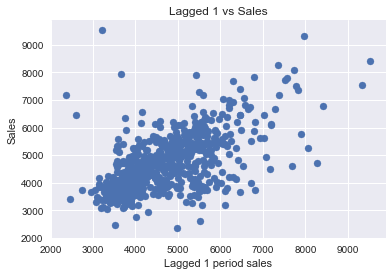

In [149]:
#Creating a lagged variable of 1 period using sales data with no weekends included in dataset
lagtr = benchmarkvalues[:(len(benchmarkvalues)-1)]
plt.subplot(111) 
plt.scatter(lagtr,benchmarkvalues[1:])
plt.xlabel('Lagged 1 period sales')
plt.ylabel('Sales')
plt.title('Lagged 1 vs Sales')

Appears to be a strong linear relationship from this, so it appears that AR(1) model is suitable.

# AR, MA, ARIMA Model

In [ ]:
#ARIMA requires numpy array to be type float, so we cast it as float
floatbenchmarkvalues = benchmarkvalues.astype(float)

In [16]:
def modelAR(tsdata):
    """Plot AR Model."""
    model = ARIMA(tsdata, order=(1, 0, 0))  
    results_AR = model.fit(disp=-1)  
    plt.plot(tsdata)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('AR(1) Model RSS: %.4f'% sum((results_AR.fittedvalues-tsdata)**2))

In [17]:
def modelMA(tsdata):
    """Plot MA Model."""
    model = ARIMA(tsdata, order=(0, 0, 1))  
    results_MA = model.fit(disp=-1)  
    plt.plot(tsdata)
    plt.plot(results_MA.fittedvalues, color='red')
    plt.title('MA(1) Model RSS: %.4f'% sum((results_MA.fittedvalues-tsdata)**2))

In [216]:
def modelARIMA(tsdata):
    """Compute optimal parameters for ARIMA Model."""
    bestresult = 10000000000000
    pOpt = 0
    qOpt = 0
    for p in range(1,6):
        for q in range(1,6):
            try:
                model = ARIMA(tsdata, order=(p, 0, q))  
                results_ARIMA = model.fit(disp=-1)  
                newresult = sum((results_ARIMA.fittedvalues-tsdata)**2)
                if newresult < bestresult:
                    pOpt = p
                    qOpt = q
            except:
                # ignore the error and go on
                pass
    #Plot final model
    model = ARIMA(tsdata, order=(pOpt, 0, qOpt))  
    finalresults_ARIMA = model.fit(disp=-1)  
    plt.plot(tsdata)
    plt.plot(finalresults_ARIMA.fittedvalues, color='red')
    word = 'ARIMA ' + str(pOpt) + ',' + str(qOpt)
    plt.title(word + ' RSS: %.4f'% sum((results_ARIMA.fittedvalues-tsdata)**2))

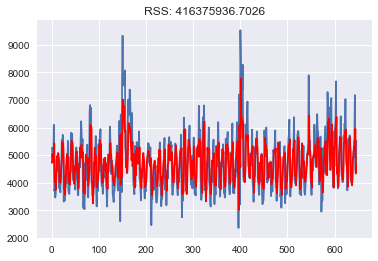

In [181]:
#Testing it for an ARMA(2,4)
model = ARIMA(floatbenchmarkvalues, order=(2, 0, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(floatbenchmarkvalues)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-floatbenchmarkvalues)**2))

Residual analysis to see if we missed anything.

https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  647
Model:                     ARMA(2, 1)   Log Likelihood               -5270.913
Method:                       css-mle   S.D. of innovations            834.993
Date:                Sat, 14 Oct 2017   AIC                          10551.826
Time:                        14:39:30   BIC                          10574.188
Sample:                             0   HQIC                         10560.502
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4723.1968     75.066     62.920      0.000    4576.069    4870.324
ar.L1.y        1.2101      0.207      5.851      0.000       0.805       1.615
ar.L2.y       -0.3836      0.123     -3.130      0.0

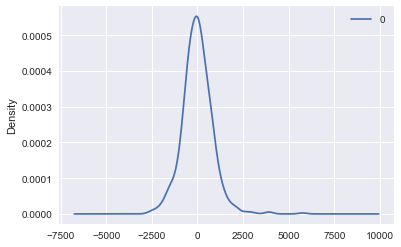

In [179]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

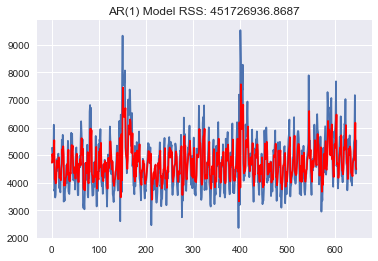

In [159]:
modelAR(floatbenchmarkvalues)

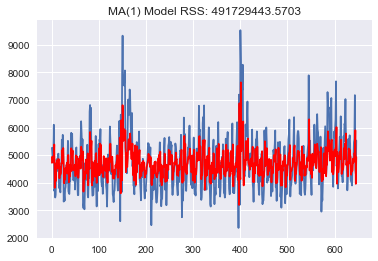

In [180]:
modelMA(floatbenchmarkvalues)

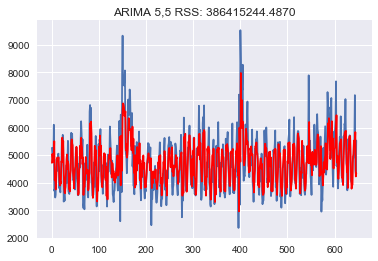

In [218]:
modelARIMA(floatbenchmarkvalues)

# Appears that AR, MA, and ARIMA do quite poorly.

# Code from tutorial

In [8]:
benchmarkdata = processdata2(1, False)
finalbench = benchmarkdata.set_index('Date')

In [10]:
y = finalbench['Sales']

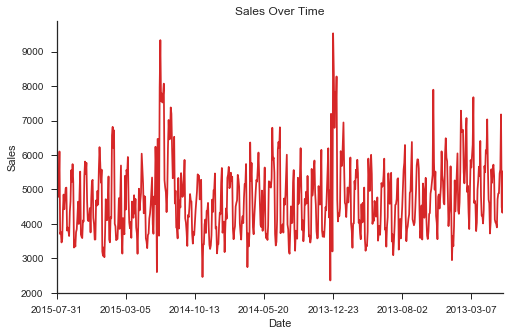

In [15]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales Over Time')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

# IGNORE ANYTHING PAST HERE AS THIS IS ATTEMPTING TO REMODEL THE TIME SERIES AS CROSS SECTIONAL


# Feature Engineering

In [29]:
#Trying for one store first so only keeping store one first
data = pd.read_csv('Rossman Sales.csv')
finaldata = data[data['Store'] ==1]

In [30]:
#Converts the date into year and month separately
finaldata['Year'] = finaldata['Date'].apply(lambda x: int(str(x)[:4]))
finaldata['Month'] = finaldata['Date'].apply(lambda x: int(str(x)[5:7]))
del finaldata['Date']

#Converts the stateholiday column into dummy variables to indicate which holiday
dummies = pd.get_dummies(finaldata[['StateHoliday']],  drop_first=True)
finaldata=finaldata.join(dummies)
finaldata.rename(columns={'StateHoliday_0':'NoHoliday','StateHoliday_a': 'PublicHoliday', 'StateHoliday_b': 'EasterHoliday', 'StateHoliday_c':'ChristmasHoliday'}, inplace=True)
del finaldata['StateHoliday']

#All store 1 so we can just delete this
del finaldata['Store']

finaldata
final_train = finaldata.sample(frac=0.6, random_state=450411920)
final_test = finaldata[finaldata.index.isin(final_train.index)==False]
#Now we have final train/test which only has predictors whilst y_train/test are the response
y_train = final_train.pop('Sales')
y_test = final_test.pop('Sales')

# Model Building

In [31]:
RandFor = RandomForestRegressor()
RandFor.fit(final_train,y_train)
prediction = RandFor.predict(final_test)

In [50]:
Tree = ExtraTreesRegressor()
Tree.fit(final_train,y_train)
prediction4 = Tree.predict(final_test)

In [51]:
print(r2_score(y_test,prediction4))

0.979629322437


In [34]:
mean_squared_error(y_test,prediction)

80037.085039787809

In [42]:
print(r2_score(y_test,prediction))

0.979366293618


In [43]:
Grad = GradientBoostingRegressor()
Grad.fit(final_train,y_train)
prediction2 = Grad.predict(final_test)
r2_score(y_test,prediction2)

0.98406586570284538

In [48]:
Ada = AdaBoostRegressor()
Ada.fit(final_train,y_train)
prediction3 = Ada.predict(final_test)
r2_score(y_test,prediction3)

0.97807884754179075

In [52]:
r2_score(y_test,((prediction+prediction2+prediction3+prediction4)/4))

0.98320835504917747

# Model to generate forecasts for all stores

In [117]:
#Trying for one store first so only keeping store one first
finaldata = pd.read_csv('Rossman Sales.csv')
#finaldata = data[data['Store'] ==1]

In [118]:
#Converts the date into year and month separately
finaldata['Year'] = finaldata['Date'].apply(lambda x: int(str(x)[:4]))
finaldata['Month'] = finaldata['Date'].apply(lambda x: int(str(x)[5:7]))
del finaldata['Date']

#Converts the stateholiday column into dummy variables to indicate which holiday
dummies = pd.get_dummies(finaldata[['StateHoliday']],  drop_first=True)
finaldata=finaldata.join(dummies)
finaldata.rename(columns={'StateHoliday_0':'NoHoliday','StateHoliday_a': 'PublicHoliday', 'StateHoliday_b': 'EasterHoliday', 'StateHoliday_c':'ChristmasHoliday'}, inplace=True)
del finaldata['StateHoliday']

In [119]:
finaldata['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

There are 1115 stores in total

In [120]:
def splittingdata(dataused):
    final_train = dataused.sample(frac=0.6, random_state=450411920)
    final_test = dataused[dataused.index.isin(final_train.index)==False]
    y_train = final_train.pop('Sales')
    y_test = final_test.pop('Sales')
    return final_train,final_test,y_train,y_test

In [121]:
def predictingmodel(final_train,final_test,y_train,y_test):
    Grad = GradientBoostingRegressor()
    Grad.fit(final_train,y_train)
    prediction = Grad.predict(final_test)
    r2score = r2_score(y_test,prediction)
    mse = mean_squared_error(y_test,prediction)
    return prediction, r2score, mse

In [128]:
storenum = range(1,1116)
forecasts = []
actualvalue = []
rsquared = []
msevalues = []
#Helps to forecast for each store
for num in storenum:
    tempdata = finaldata.copy()
    storeforecasted = tempdata[tempdata['Store'] ==num]
    final_train, final_test, y_train, y_test = splittingdata(storeforecasted)
    forecastvalue, r2value, msevalue = predictingmodel(final_train, final_test, y_train, y_test)
    forecasts.append(forecastvalue)
    actualvalue.append(y_test)
    rsquared.append(r2value)
    msevalues.append(int(msevalue))

In [126]:
#Length of forecast list matches the number of stores
len(forecast)

1115

In [127]:
forecasts[0]

array([  4.93607072e+03,   4.71066457e+03,   5.77855604e+03,
         4.22379687e+03,   4.71066457e+03,   5.01836274e+03,
         5.02905282e+03,   3.25303815e+01,   3.61661704e+03,
         3.90752629e+03,   3.91173963e+03,   4.38382523e+03,
         4.73881536e+03,   5.27388384e+03,   3.25303815e+01,
         3.39876409e+03,   3.08924014e+03,   3.25303815e+01,
         4.03316637e+03,   3.25303815e+01,   4.16361123e+03,
         3.80166896e+03,   5.62216348e+03,   5.71473913e+03,
         4.88559969e+03,   4.31275801e+03,   3.82399480e+03,
         1.88523706e+01,   4.19893828e+03,   4.78901373e+03,
         5.38321344e+03,   8.62209239e+00,   3.32241563e+03,
         3.48111176e+03,   5.11697369e+03,   4.78901373e+03,
         5.50899614e+03,   5.99215109e+03,   4.94595888e+03,
         2.08550124e+01,   4.37073767e+03,   2.99485867e+03,
         4.47044259e+03,   4.82420082e+03,   5.36745327e+03,
         3.39575486e+03,   4.94631470e+01,   7.15644853e+03,
         5.39846451e+03,

In [129]:
actualvalue[0]

1115       5020
2230       4782
4460       6102
12265      4395
16725      4427
18955      5042
20070      5054
21185         0
23415      3808
25645      3797
26760      3650
27875      4359
30105      4797
34565      5735
36795         0
40140      3533
41255      3346
44600         0
45715      4097
52405         0
53520      4256
61325      4183
62440      5384
64670      5809
69130      5592
70245      4656
71360      4111
75820         0
76935      4276
80280      4735
           ... 
912400     4293
920205     7285
923550     6729
926895     5506
929125     5598
931355     7072
934700     4925
935815     5108
941390     5578
944735     5973
946965     7675
951425     4676
953655     3794
957000     5237
963690        0
964805     6154
968150     4252
970380     4409
972610     5370
973725     5681
977070     6049
980415     5970
991565     5578
992680     5720
998255     4044
1008290    5580
1009405    7176
1010520       0
1014980    5530
1016095       0
Name: Sales, Length: 377

In [134]:
rsquared[0]

0.9840938822341887